# Tarea 2 
## Pablo Barranco Soto
## 151528

Utilizando los datos de Diabetes en mujeres de la India, queremos predecir si una mujer tendrá o no diabetes con las variables con las que contamos. Para esto primero cargamos los datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_auc_score, accuracy_score, f1_score, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [25]:
# Importamos nuestros datos
diabetes = pd.read_csv('data/diabetes.csv')

# Damos formato al dataset
diabetes.rename(columns={col: col.lower() for col in diabetes.columns.values}, inplace=True)
diabetes.rename(columns={col: col.replace(' ','_').replace('/','_') for col in diabetes.columns.values}, inplace=True)

# Fijamos la Semilla
np.random.seed(20201101)

In [3]:
# Preparamos los datos para introducir al modelo
y = diabetes.outcome
X = diabetes.drop(['outcome'], axis=1)

## 1. ¿Cuál es la etiqueta positiva?

<font color='blue'>La etiqueta positiva es $1$. Es decir si $\textit{outcome} = 1$, el paciente observado padece de diabetes.</font>  

## 2. Divide el conjunto de datos para que el 25% de los datos sean de pruebas. ¿Cuántas observaciones tienes en entrenamiento y pruebas?

In [4]:
# Train test split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25)
print("\nX_train, y_train: ", (X_train.shape, y_train.shape))
print("\nX_test, y_test: ", (X_test.shape, y_test.shape))


X_train, y_train:  ((576, 8), (576,))

X_test, y_test:  ((192, 8), (192,))


<font color='blue'>En total tenemos 768 observaciones. Al separar el conjunto en _train_ y _test_ tenemos:
* Observaciones de entrenamiento: 576
* Observaciones de prueba: 192</font>

## Utiliza un _GridSearchCV_ con los siguientes hiperparámetros:
* Profundidad: 5,10,15
* Mínimo número de elementos para definir una hoja: 3,5,7
* Cross validation: 10
* Scoring: Eficiencia

In [5]:
# Creamos el Grid Search
dt = DecisionTreeClassifier()
grid = {'min_samples_leaf': [3,5,7], 'max_depth' : [5,10,15]}
gs = GridSearchCV(dt, param_grid=grid, scoring='precision', cv=10, n_jobs=-1, return_train_score=True)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'mi

In [6]:
#Mejores parametros de la busqueda
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 7}

## 3. ¿Cuántos modelos generarás?

<font color='blue'> Generaremos en total $3 * 3 = 9$ modelos. </font>

## 4. ¿Cuál es la variable que está en la raíz?

<Figure size 432x288 with 0 Axes>

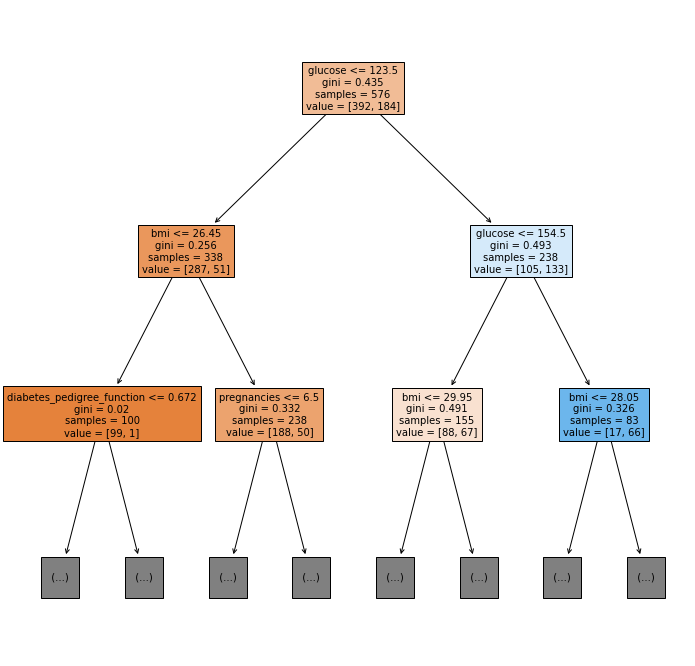

In [7]:
# Ploteamos el arbol para ver la raiz
plt.clf() 
fig, ax = plt.subplots(figsize=(12, 12))
plot_tree(gs.best_estimator_,max_depth=2,feature_names = list(diabetes.columns), fontsize=10, filled = True)
plt.show()

<font color='blue'> Podemos ver que la variable de la raiz es _glucose_.<font>

## 5. ¿Cuáles son las 3 variables que aportan más información a la predicción?

In [8]:
# Creamos un data frame con la importancia de cada variable
feature_importances_df = pd.DataFrame({'feature': X.columns.values, 
                                       'importance': gs.best_estimator_.feature_importances_})
feature_importances_df.sort_values(by="importance", ascending=False, inplace = True)
feature_importances_df[0:3]

,feature,importance
1,glucose,0.620417
5,bmi,0.165616
6,diabetes_pedigree_function,0.065305


<font color='blue'> Las Variables que mas aportan informacion a la prediccion son $\textit{glucose}$, $\textit{bmi}$ y $\textit{diabetes_pedigree_function}$.</font>

Ahora eliminamos las variables que tienen menos del 7% de importancia y volvemos a generar un _GridSearchCV_ con los mismos hiperparámetros que configuraste anteriormente.


In [9]:
# Filtramos las variables que se quedan y las ponemos en un nuevo df X_train_2
se_quedan = list(feature_importances_df.feature[feature_importances_df.importance >= 0.07])
X_train_2 = X_train.filter(se_quedan, axis = 1)
X_test_2 = X_test.filter(se_quedan, axis = 1)

# Volvemos a hacer el grid Search con los mismos parametros
gs.fit(X_train_2, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'mi

## 6. ¿Qué hiperparámetros tiene el mejor modelo?

In [10]:
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 5}

<font color='blue'> Los mejores parametros fueron:
* Profundidad = 5
* Minino elementos en una hoja = 5 <font>

## 7. ¿Cuál es el punto de corte del modelo que cumple con las restricciones de negocio (4 decimales)?

Restriccion de negocio : _Podemos tener estrictamente menos del 10% (sin incluirlo) en equivocaciones del tipo: predicción diabetes y no tener diabetes._

In [11]:
# Hacemos predicciones con nuestro modelo entrenado
predictions_labels = gs.predict(X_test_2)
predictions_scores = gs.predict_proba(X_test_2)
fpr, tpr, thresholds = roc_curve(y_test, predictions_scores[:,1], pos_label=1)

In [12]:
# Construimos tabla de Metricas
metricas = pd.DataFrame({'threshold': thresholds, 'tpr': tpr, 'fpr': fpr})
metricas['tnr'] = 1 - metricas.fpr
metricas['fnr'] = 1 - metricas.tpr
metricas['precision'] = metricas.tpr/(metricas.tpr + metricas.fpr)
metricas['recall'] = metricas.tpr/(metricas.tpr + metricas.fnr)
metricas

,threshold,tpr,fpr,tnr,fnr,precision,recall
0,2.000000,0.000000,0.000000,1.000000,1.000000,NaN,0.000000
1,1.000000,0.035714,0.000000,1.000000,0.964286,1.000000,0.035714
2,0.892857,0.309524,0.046296,0.953704,0.690476,0.869888,0.309524
3,0.800000,0.321429,0.046296,0.953704,0.678571,0.874101,0.321429
4,0.750000,0.333333,0.055556,0.944444,0.666667,0.857143,0.333333
5,0.714286,0.333333,0.064815,0.935185,0.666667,0.837209,0.333333
6,0.666667,0.404762,0.092593,0.907407,0.595238,0.813830,0.404762
7,0.545455,0.428571,0.120370,0.879630,0.571429,0.780723,0.428571
8,0.544118,0.607143,0.231481,0.768519,0.392857,0.723975,0.607143
9,0.500000,0.619048,0.250000,0.750000,0.380952,0.712329,0.619048


In [13]:
threshold = metricas.threshold[metricas.fpr < .1].min()

In [14]:
labels_threshold = [0 if score < threshold else 1 for score in predictions_scores[:,1]]
threshold

0.6666666666666666

<font color='blue'>El punto de corte es en 0.6667<font>

## 8. ¿Qué porcentaje de FNR tendremos?

In [15]:
# Lo buscamos en la tabla
metricas.fnr[metricas.threshold == threshold]

6    0.595238
Name: fnr, dtype: float64

In [26]:
# PAra comprobar calculamos los TP FP TN FN manualmente 
df = pd.DataFrame({'predicted': labels_threshold, 'true_label': y_test})
df['tp'] = df[['predicted','true_label']].apply(lambda x: 1 if x.true_label == 1 and x.predicted == x.true_label else 0, axis=1)
df['fn'] = df[['predicted','true_label']].apply(lambda x: 1 if x.true_label == 1 and x.predicted != x.true_label else 0, axis=1)
df['tn'] = df[['predicted','true_label']].apply(lambda x: 1 if x.true_label == 0 and x.predicted == x.true_label else 0, axis=1)
df['fp'] = df[['predicted','true_label']].apply(lambda x: 1 if x.true_label == 0 and x.predicted != x.true_label else 0, axis=1)
TP = df.tp.sum()
FP = df.fp.sum()
TN = df.tn.sum()
FN = df.fn.sum()

In [17]:
# Porcentaje FNR
FN/(FN+TP)

0.5952380952380952

<font color='blue'>El _FNR_ obtenido en este momento es $0.059$<font>

## 9. ¿Qué eficiencia tiene el modelo en ese punto?

In [18]:
metricas.precision[metricas.threshold == threshold]

6    0.81383
Name: precision, dtype: float64

In [19]:
TP/(TP+FP)

0.7727272727272727

<font color='blue'> no se porque razon obtengo diferentes resultados al observar el valor de la tabla y compararrlo con el calculo de la presicion/ eficiencia en ese punto. Algo debi haber hecho mal pero confio mas en el calculado $0.77$<font>

## 10. ¿Cuál es la matriz de confusión asociada a ese punto de corte?

<font color='blue'> La matriz de connfusión asociada a este punto de corte se muestra a continuación.<font>

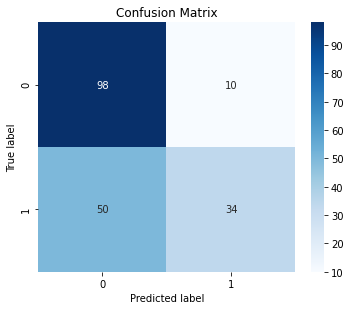

In [20]:
mat = confusion_matrix(y_test, labels_threshold)
# Ploteamos la Matriz
figure = plt.figure(figsize=(5, 4))
sns.heatmap(mat, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.show()